# How to calculate coherence lifetime of eddies

In this notebook I have collected the functions that are needed to go from ocean parcels trajectory dataset to **(1)** calculate LAVD cumulatevly for all time steps in the trajectory dataset, **(2)** identify RCLVs in all these LAVD fields.

The wast majority of functions are taken from or hevily inspired by RCLVatlas by Lexi Jones-Kellet from MIT.

In [1]:
import os,sys
import trajan
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cmocean
from datetime import datetime
import pandas as pd
from shapely.geometry import Polygon
import geopandas as gpd
import pyproj

from config import *

sys.path.append('./RCLVatlas')
from subfunctions_for_RCLV_atlas import read_RCLV_CSV_untracked,read_RCLV_CSV_tracked,save_RCLV_CSV
from mainfunctions_for_RCLV_atlas import *
from functions_for_parcels import *
from scipy import integrate

## Input data 

Here we use ocean parcels .zarr dataset of 32 days as input. 

30x30 degree box around Hawaii

In [3]:
traj_path= "/work/bk1377/b382618/RCLVs/f32day/lang_traj/20100423_32days_runtime_20min_timestep_particle_start_lat_10.0_40.0_lon_180.0_210.0_spatial_step_0.03125_6hr_output_freq.zarr"

In [4]:
base_path = "/work/bk1377/b382618/LAVD_days_function/"

## Calculate LAVD for all days in the trajectory dataset

The function calculates LAVD for all trajectory time stepas in the dataset. For example, LAVD for day 7 out of 32 will integrate from time=0 to time=7 days. The original LAVD function (like in RCLV) usually integrate only the full trajectory lifetime. Here daily snapshots are available.


In [14]:
# a bit weirf function to deal with different date formats in different datasets
#this function is from chatgpt
def cleanup_nc_time_format(time_str):
    """
    Removes the last three zeros (microseconds) from a .nc file time string.
    
    Parameters:
    time_str (str): Time string in the format "2010-05-24T18:00:00.000000000"
    
    Returns:
    str: Time string with the last three zeros removed, in the format "2010-05-24T18:00:00"
    """
    if '.' in time_str:
        time_str = time_str[:time_str.index('.')]
    time_obj = datetime.datetime.strptime(time_str, "%Y-%m-%dT%H:%M:%S")
    
    return time_obj.strftime("%Y-%m-%dT%H:%M:%S")

In [15]:
# this is the real function, pls don't delete it
def calc_LAVD_spec_time(vort,output_freq,runtime, LAVD_days):
    time_select=int(LAVD_days*(24/output_freq))


    
    vort_avg_t = np.nanmean(vort,axis=0)[0:] #Find average vorticity over the entire spatial domain at each time step
    
    if LAVD_days==0:
        LAVD = np.absolute(vort[:,0]-vort_avg_t[0]) #this is just vorticity field
        # LAVD = np.trapezoid(np.absolute(vort[:,0:time_select] - vort_avg_t[0:time_select]), dx=output_freq*60*60, axis=1)/(time_select*6*60*60-output_freq*60*60) #trapz does the integration; convert data to be in se
        # LAVD = np.trapezoid(np.absolute(vort[:,0:time_select] - vort_avg_t[0:time_select]), dx=output_freq*60*60, axis=1) #trapz does the integration; convert data to be in se

    else:
        # LAVD = integrate.cumulative_trapezoid(np.absolute(vort[:,0:time_select] - vort_avg_t[0:time_select]), dx=output_freq*60*60, axis=1)/(LAVD_days*24*60*60-output_freq*60*60)
        ### if i do the above then the values at 0 are small and correct at the end.
        LVD = integrate.cumulative_trapezoid(np.absolute(vort[:,0:time_select] - vort_avg_t[0:time_select]), dx=output_freq*60*60, axis=1)   
        # LAVD = np.trapezoid(np.absolute(vort[:,0:time_select] - vort_avg_t[0:time_select]), dx=output_freq*60*60, axis=1)/(LAVD_days*24*60*60-output_freq*60*60) #trapz does the integration; convert data to be in se
    return LVD, time_select


In [16]:
def trajectories_to_specific_day_LAVD(traj_path, LAVD_days):
    print("Calculating the LAVD ...")
    traj_ds = xr.open_dataset(traj_path) # open the Lagrangian trajectory dataset that was just produced
    date = str(traj_ds.time.values[0][0])[0:10]
    vort_premask = traj_ds.variables["vort"]
    vort = np.array(vort_premask.where(vort_premask != 0)) #filters out land values
    LVD, time_select = calc_LAVD_spec_time(vort,sim_params['output_freq'],sim_params['runtime'], LAVD_days)


    # z=sim_params['output_freq']*60*60
    divide_by_list = []
    for i in np.arange(2, time_select+1):
        val = (i*sim_params['output_freq']*60*60-sim_params['output_freq']*60*60)
        divide_by_list.append(val)
    LAVD = LVD/divide_by_list

    # Create an xarray Dataset with the necessary dimensions
    one_lat = np.unique(traj_ds.lat[:,0])
    one_lon = np.unique(traj_ds.lon[:,0])
    time = traj_ds.time[0][1:time_select].values
    # cleaned_time_strings = np.vectorize(cleanup_nc_time_format)(time_strings)
    time2= np.vectorize(cleanup_nc_time_format)(time.astype(str))
    print(time2)

    # Check the shape of LAVD and reshape it    
    # Reshape LAVD from (921600, 17) to (17, 960, 960)
    num_lat = len(one_lat)
    num_lon = len(one_lon)
    num_time = len(time2)
    
    if LAVD.shape == (num_lat * num_lon, num_time):
        LAVD = np.reshape(LAVD, (num_lon, num_lat, num_time))
    else:
        raise ValueError(f"Unexpected LAVD shape {LAVD.shape}. Cannot reshape.")
    
    LAVD_ds = xr.Dataset(
        {
            'LAVD': (['longitude', 'latitude', 'time'], LAVD)
        },
        coords={
            'time': time2,
            'latitude': one_lat,
            'longitude': one_lon
        }
    )

    date_good=str(date.replace("-", ""))
    output_file_name = str(date_good) + "_" + str(LAVD_days) + "days_LAVD.nc"
    # Save the dataset as a NetCDF file
    LAVD_output_file_path = os.path.join(base_path, output_file_name)
    LAVD_ds.to_netcdf(LAVD_output_file_path)
    
    print('LAVD NetCDF output file: %s' % (LAVD_output_file_path))
    return LAVD_output_file_path


In [17]:
out_p = trajectories_to_specific_day_LAVD(traj_path, 32)

Calculating the LAVD ...


/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


['2010-04-23T06:00:00' '2010-04-23T12:00:00' '2010-04-23T18:00:00'
 '2010-04-24T00:00:00' '2010-04-24T06:00:00' '2010-04-24T12:00:00'
 '2010-04-24T18:00:00' '2010-04-25T00:00:00' '2010-04-25T06:00:00'
 '2010-04-25T12:00:00' '2010-04-25T18:00:00' '2010-04-26T00:00:00'
 '2010-04-26T06:00:00' '2010-04-26T12:00:00' '2010-04-26T18:00:00'
 '2010-04-27T00:00:00' '2010-04-27T06:00:00' '2010-04-27T12:00:00'
 '2010-04-27T18:00:00' '2010-04-28T00:00:00' '2010-04-28T06:00:00'
 '2010-04-28T12:00:00' '2010-04-28T18:00:00' '2010-04-29T00:00:00'
 '2010-04-29T06:00:00' '2010-04-29T12:00:00' '2010-04-29T18:00:00'
 '2010-04-30T00:00:00' '2010-04-30T06:00:00' '2010-04-30T12:00:00'
 '2010-04-30T18:00:00' '2010-05-01T00:00:00' '2010-05-01T06:00:00'
 '2010-05-01T12:00:00' '2010-05-01T18:00:00' '2010-05-02T00:00:00'
 '2010-05-02T06:00:00' '2010-05-02T12:00:00' '2010-05-02T18:00:00'
 '2010-05-03T00:00:00' '2010-05-03T06:00:00' '2010-05-03T12:00:00'
 '2010-05-03T18:00:00' '2010-05-04T00:00:00' '2010-05-04T06:00

## Identify RCLVs in the created LAVD daily fields

In [2]:
nc_file_path = "/work/bk1377/b382618/LAVD_days_function/20100423_32days_LAVD.nc"

In [3]:
traj_path= "/work/bk1377/b382618/RCLVs/f32day/lang_traj/20100423_32days_runtime_20min_timestep_particle_start_lat_10.0_40.0_lon_180.0_210.0_spatial_step_0.03125_6hr_output_freq.zarr"

In [4]:
def extract_particles_after_time_for_LAVD(traj,x_mask,y_mask,traj_lat_array,sim_params,obs_to_select):
    """
    Get the lat/lons of particles from a ploygon after some number of days along the Lagrangian trajectory.
    
    Input
        traj: trajectory file 
        x_mask,y_mask: indeces from the longitude & latitude arrays that are inside of the polygon
        days: number of days from the initialization time to retreive particle locations (back trajectories will be back in time)
    Output
        eddy_xdays_lons,eddy_xday_lats: lon/lat coordinates of the particles of interest on day x
    
    """
    particle_lon,particle_lat,particle_vort = traj.variables["lon"],traj.variables["lat"],traj.variables["vort"] #read in particle location lat, lons, vorts
    particle_nums = x_mask*len(traj_lat_array) + y_mask #formula to get the integer ID of the particles inside a polygon
    if obs_to_select==0: ### not sure if this if statement is needed
        eddy_xday_lons = [float(particle_lon[p,int(((24/sim_params['output_freq'])*obs_to_select))]) for p in particle_nums]   
        eddy_xday_lats = [float(particle_lat[p,int(((24/sim_params['output_freq'])*obs_to_select))]) for p in particle_nums]
        eddy_xday_vorts = [float(particle_vort[p,int(((24/sim_params['output_freq'])*obs_to_select))]) for p in particle_nums]

    else:
######Stella- added -1 to the int bc i though that the indexing does not work bc of that. i think it should be like that because it is indexing         
        eddy_xday_lons = [float(particle_lon[p,int(obs_to_select)]) for p in particle_nums]   
        eddy_xday_lats = [float(particle_lat[p,int(obs_to_select)]) for p in particle_nums]
        eddy_xday_vorts = [float(particle_vort[p,int(obs_to_select)]) for p in particle_nums]
    return eddy_xday_lons,eddy_xday_lats,eddy_xday_vorts

### Without saving rejected ones

In [5]:


def LAVD_days_to_RCLV_loop(traj_ds_path, LAVD_ds_path):
    RCLV_data = [['date', 'RCLV_id', 'orientation', 'age_days', 'area_km2', 'center_lon', 'center_lat', 'CD', 'flag', 'boundary_coords']]

    traj_ds = xr.open_zarr(traj_ds_path)
    lavd_ds = xr.open_dataset(LAVD_ds_path)
    lavd_ds = lavd_ds.LAVD
    
    time_list = traj_ds.time[0].values
    midnight_list = time_list[::4]

    # midnight_list = midnight_list[9:]
    # midnight_list = midnight_list[1:] #this removes the first date when particles start, so the first RCLVS will be identified at 1 day later
    print(midnight_list)

    # ## now i need to itterate the midnight list
    # plms_cum,cons_cum,areas_cum,cds_cum,pols_cum = [],[],[],[],[]
    for sk in np.arange(25, 30):
        ## select the right LAVD field
        right_date = midnight_list[sk]
        print(right_date)
        short_date=str(right_date)[0:19]
        print(short_date)
        lavd_subselect = lavd_ds.sel(time=short_date)
        #select subselect the lavd field 
        traj_subselect = traj_ds.isel(obs = slice(0, sk*4))
        
        # LAVD = np.load('%s%s_LAVD_%s.npy'%(LAVD_dir,initial_date,filename_str)) #Load LAVD data
        LAVD = np.ma.masked_where(np.isnan(lavd_subselect),lavd_subselect) #Land mask required for the peak_local_max function to work
        LAVD_reshape = np.transpose(np.reshape(LAVD,(len(traj_lon_array),len(traj_lat_array))))
        
        # Iterate through all of the local maxima to find structures that meet our RCLV criteria 
        plms,cons,areas,cds,pols = [],[],[],[],[] # arrays to store the output
        plm = peak_local_max(LAVD_reshape,min_distance=RCLV_params['min_dist']) # grid indices of the local maxima in the LAVD field
        for ji in plm:
            args = {'lon0':traj_lon_array[ji[1]],
                    'lat0':traj_lat_array[ji[0]],
                    'dlon':np.abs(traj_lon_array[1]-traj_lon_array[0]),
                    'dlat':np.abs(traj_lat_array[1]-traj_lat_array[0])}
            
            for target_CD in [0.03,0.02,0.01]: #target CDs to test, will iterate through each of these unless if a successful contour is identified
                con,area,cd = rclv.convex_contour_around_maximum(LAVD_reshape,ji,
                                                                 init_contour_step_frac=RCLV_params['init_contour_step_frac'],
                                                                 convex_def_tol=RCLV_params['convex_def_tol'],
                                                                 convex_def=target_CD)
            
                try: # Code errors if the local maximum is too close to the land where there are missing values
                    if (area >= RCLV_params['min_area']) and (cd <= 0.03): # check area and convex deficiency meet thresholds; actual cd identified will be different from target CD
                        lon_inds = [round(i) for i in con[:,1]]
                        lat_inds = [round(i) for i in con[:,0]]
    
                        # Reformat points of the polygon with parentheses
                        poly_pts = [(traj_lon_array[lon_inds][pt],traj_lat_array[lat_inds][pt]) for pt in np.arange(0,len(lon_inds))]
    
                        # Get the CI of the particles after simulation run time to make sure it meets threshold set
                        x_mask,y_mask = find_polygon_pts(poly_pts,traj_lon_array,traj_lat_array)                    
                        eddy_day0_lons,eddy_day0_lats,_ = extract_particles_after_time_for_LAVD(traj_subselect,x_mask,y_mask,traj_lat_array,sim_params,0) #day 0 data
                        eddy_dayx_lons,eddy_dayx_lats,eddy_dayx_vorts = extract_particles_after_time_for_LAVD(traj_subselect,x_mask,y_mask,traj_lat_array,sim_params,sk) # last day
                        contour_CI = CI(eddy_day0_lons,eddy_day0_lats,eddy_dayx_lons,eddy_dayx_lats) #calculate the coherency index (measure of dispersal)
                        
                        if (contour_CI >= -0.5): # Coherency index criteria, minimal dispersal required
                            # Check that the vorticty is consistent within the vortex over the course of the simulation (filters out some weird saddle point features,etc)
                            # Timestep to get initial vorticity needs to be day 1 since at day 0 all particles are initialized with vort=0
                            eddy_day1_lons,eddy_day1_lats,eddy_day1_vorts = extract_particles_after_time(traj_subselect,x_mask,y_mask,traj_lat_array,sim_params,1) 
                            day1_vort_signs = [np.sign(v) for v in eddy_day1_vorts]
                            day1_anti_count,day1_cyc_count = day1_vort_signs.count(-1.0),day1_vort_signs.count(1.0)  
                            day1_vort_freq = np.max((day1_anti_count,day1_cyc_count))/(day1_anti_count+day1_cyc_count) #percentage of particles with the same vorticity
    
                            if (day1_vort_freq >= 0.85): # 85% or more have the same vort sign on day 1
                                dayx_vort_signs = [np.sign(v) for v in eddy_dayx_vorts]
                                dayx_anti_count,dayx_cyc_count = dayx_vort_signs.count(-1.0),dayx_vort_signs.count(1.0)  
                                dayx_vort_freq = np.max((dayx_anti_count,dayx_cyc_count))/(dayx_anti_count+dayx_cyc_count)
    
                                if day1_anti_count > day1_cyc_count: #get the polarity of the vortex on day 1
                                    day1_vort_pol = 'anti'
                                else:
                                    day1_vort_pol = 'cyc'
                                if dayx_anti_count > dayx_cyc_count: #get the polarity of the vortex on last day
                                    dayx_vort_pol = 'anti'
                                else:
                                    dayx_vort_pol = 'cyc'

                                # If all criteria are passed, add values to output arrays & move on to next local maxima
                                if (dayx_vort_freq >= 0.85) and (day1_vort_pol == dayx_vort_pol): # Final criteria: vort is consistent for 85% of particles on the last day
                                    region_area = rclv.polygon_area(rclv.project_vertices(con, **args)) #Convert area units from pixels to m^2
                                    plms.append(ji)
                                    cons.append(con)
                                    areas.append(region_area/(10**6)) #convert from m^2 -> km^2
                                    cds.append(cd)
                                    pols.append(day1_vort_pol)
                                    break # do not need to look at other CDs if the criteria to this point has been met 
                except TypeError: # too close to land to define an RCLV
                    break
#### save the rclvs in a file
                for i in np.arange(0,len(cons)):
                    temp = [short_date,np.nan,pols[i],np.nan,areas[i],traj_lon_array[plms[i][1]],traj_lat_array[plms[i][0]],cds[i],0] 
                    # Convert from grid indices to lat/lon coordinates for the output
                    lon_bounds = traj_lon_array[[round(j) for j in cons[i][:, 1]]]
                    lat_bounds = traj_lat_array[[round(j) for j in cons[i][:, 0]]]
                    for j in np.arange(0,len(lon_bounds)):
                        temp.extend([lon_bounds[j],lat_bounds[j]])
                    RCLV_data.append(temp) # Add RCLV data to main array
                    # temp = []
                plms,cons,areas,cds,pols = [],[],[],[],[] # if yoou don't do this then 
    return RCLV_data

### This function saves all identified and rejected contours for more interesting analysis. 


Filter for "accepted" to get the "real" RCLVs.
So the function ooutputs all RCLVs from all LAVD_days LAVD fields.
THe basis for this is lexiland function that is made to take in .nc fles and alsp output the rejected RCLVs so we see why the coherence ends


In [5]:
def LAVD_days_to_RCLV_loop(traj_ds_path, LAVD_ds_path):
    RCLV_data = [['date', 'reject_accept', 'RCLV_id', 'orientation', 'age_days', 'area_km2', 'center_lon', 'center_lat', 'CD', 'CI', 'flag', 'boundary_coords']]
    # RCLV_data_rejected = [['date', 'reason', 'RCLV_id', 'orientation', 'age_days', 'area_km2', 'center_lon', 'center_lat', 'CD', 'boundary_coords']]

    traj_ds = xr.open_zarr(traj_ds_path)
    lavd_ds = xr.open_dataset(LAVD_ds_path)
    lavd_ds = lavd_ds.LAVD
    
    time_list = traj_ds.time[0].values
    midnight_list = time_list[::4]

    # midnight_list = midnight_list[9:]
    # midnight_list = midnight_list[1:] #this removes the first date when particles start, so the first RCLVS will be identified at 1 day later
    print(midnight_list)

    # ## now i need to itterate the midnight list
    # plms_cum,cons_cum,areas_cum,cds_cum,pols_cum = [],[],[],[],[]
    for sk in np.arange(1, 32):
        ## select the right LAVD field
        right_date = midnight_list[sk]
        print(right_date)
        short_date=str(right_date)[0:19]
        print(short_date)
        lavd_subselect = lavd_ds.sel(time=short_date)
        #select subselect the lavd field 
        traj_subselect = traj_ds.isel(obs = slice(0, sk*4))
        
        # LAVD = np.load('%s%s_LAVD_%s.npy'%(LAVD_dir,initial_date,filename_str)) #Load LAVD data
        LAVD = np.ma.masked_where(np.isnan(lavd_subselect),lavd_subselect) #Land mask required for the peak_local_max function to work
        LAVD_reshape = np.transpose(np.reshape(LAVD,(len(traj_lon_array),len(traj_lat_array))))
        
        # Iterate through all of the local maxima to find structures that meet our RCLV criteria 
        plms,cons,areas,cds,pols,cis, rejacc = [],[],[],[],[],[],[] # arrays to store the output
        plm = peak_local_max(LAVD_reshape,min_distance=RCLV_params['min_dist']) # grid indices of the local maxima in the LAVD field
        for ji in plm:
            args = {'lon0':traj_lon_array[ji[1]],
                    'lat0':traj_lat_array[ji[0]],
                    'dlon':np.abs(traj_lon_array[1]-traj_lon_array[0]),
                    'dlat':np.abs(traj_lat_array[1]-traj_lat_array[0])}
            
            for target_CD in [0.03,0.02,0.01]: #target CDs to test, will iterate through each of these unless if a successful contour is identified
                con,area,cd = rclv.convex_contour_around_maximum(LAVD_reshape,ji,
                                                                 init_contour_step_frac=RCLV_params['init_contour_step_frac'], ##might be sensitive to the eddies i ID
                                                                 convex_def_tol=RCLV_params['convex_def_tol'],
                                                                 convex_def=target_CD)
            
                try: # Code errors if the local maximum is too close to the land where there are missing values
                    if (area < RCLV_params['min_area']):
                        rejected_reason = "rejected_min_area"
                        region_area = rclv.polygon_area(rclv.project_vertices(con, **args)) #Convert area units from pixels to m^2
                        plms.append(ji)
                        cons.append(con)
                        areas.append(region_area/(10**6)) #convert from m^2 -> km^2
                        cds.append(cd)
                        pols.append(None)
                        cis.append(None)
                        rejacc.append(rejected_reason)
                        # print(type(con))
                        continue

                    if (cd > 0.031): ### this is changed from 0.03 because it misses the contours that are above the cd threshold bu within the tolerance. 
                        rejected_reason = "rejected_cd"
                        region_area = rclv.polygon_area(rclv.project_vertices(con, **args)) #Convert area units from pixels to m^2
                        plms.append(ji)
                        cons.append(con)
                        areas.append(region_area/(10**6)) #convert from m^2 -> km^2
                        cds.append(cd)
                        pols.append(None)
                        cis.append(None)
                        rejacc.append(rejected_reason)
                        # print(type(con))
                        continue

                    

                    else:
                    # if (area >= RCLV_params['min_area']) and (cd <= 0.03): # check area and convex deficiency meet thresholds; actual cd identified will be different from target CD
                        lon_inds = [round(i) for i in con[:,1]]
                        lat_inds = [round(i) for i in con[:,0]]
   
    
                        # Reformat points of the polygon with parentheses
                        poly_pts = [(traj_lon_array[lon_inds][pt],traj_lat_array[lat_inds][pt]) for pt in np.arange(0,len(lon_inds))]
    
                        # Get the CI of the particles after simulation run time to make sure it meets threshold set
                        x_mask,y_mask = find_polygon_pts(poly_pts,traj_lon_array,traj_lat_array)                    
                        eddy_day0_lons,eddy_day0_lats,_ = extract_particles_after_time_for_LAVD(traj_subselect,x_mask,y_mask,traj_lat_array,sim_params,0) #day 0 data
                        eddy_dayx_lons,eddy_dayx_lats,eddy_dayx_vorts = extract_particles_after_time_for_LAVD(traj_subselect,x_mask,y_mask,traj_lat_array,sim_params,sk) # last day
                        contour_CI = CI(eddy_day0_lons,eddy_day0_lats,eddy_dayx_lons,eddy_dayx_lats) #calculate the coherency index (measure of dispersal)

                        if contour_CI < -0.5:
                            rejected_reason = "rejected_ci"
                            region_area = rclv.polygon_area(rclv.project_vertices(con, **args)) #Convert area units from pixels to m^2
                            plms.append(ji)
                            cons.append(con)
                            areas.append(region_area/(10**6)) #convert from m^2 -> km^2
                            cds.append(cd)
                            pols.append(None)
                            cis.append(contour_CI)
                            rejacc.append(rejected_reason)

                            continue
                        
                        else:
                        # if (contour_CI >= -0.5): # Coherency index criteria, minimal dispersal required
                            # Check that the vorticty is consistent within the vortex over the course of the simulation (filters out some weird saddle point features,etc)
                            # Timestep to get initial vorticity needs to be day 1 since at day 0 all particles are initialized with vort=0
                            eddy_day1_lons,eddy_day1_lats,eddy_day1_vorts = extract_particles_after_time(traj_subselect,x_mask,y_mask,traj_lat_array,sim_params,1) 
                            day1_vort_signs = [np.sign(v) for v in eddy_day1_vorts]
                            day1_anti_count,day1_cyc_count = day1_vort_signs.count(-1.0),day1_vort_signs.count(1.0)  
                            day1_vort_freq = np.max((day1_anti_count,day1_cyc_count))/(day1_anti_count+day1_cyc_count) #percentage of particles with the same vorticity


                            if day1_vort_freq < 0.85:
                                rejected_reason = "rejected_vort_consistency_day1"
                                region_area = rclv.polygon_area(rclv.project_vertices(con, **args)) #Convert area units from pixels to m^2
                                plms.append(ji)
                                cons.append(con)
                                areas.append(region_area/(10**6)) #convert from m^2 -> km^2
                                cds.append(cd)
                                pols.append(None)
                                cis.append(contour_CI)
                                rejacc.append(rejected_reason)

                                continue
                            else:

                            # if (day1_vort_freq >= 0.85): # 85% or more have the same vort sign on day 1
                                dayx_vort_signs = [np.sign(v) for v in eddy_dayx_vorts]
                                dayx_anti_count,dayx_cyc_count = dayx_vort_signs.count(-1.0),dayx_vort_signs.count(1.0)  
                                dayx_vort_freq = np.max((dayx_anti_count,dayx_cyc_count))/(dayx_anti_count+dayx_cyc_count)
    
                                if day1_anti_count > day1_cyc_count: #get the polarity of the vortex on day 1
                                    day1_vort_pol = 'anti'
                                else:
                                    day1_vort_pol = 'cyc'
                                if dayx_anti_count > dayx_cyc_count: #get the polarity of the vortex on last day
                                    dayx_vort_pol = 'anti'
                                else:
                                    dayx_vort_pol = 'cyc'

                                if dayx_vort_freq < 0.85:
                                    rejected_reason = "rejected_vort_consistency_lastday"
                                    region_area = rclv.polygon_area(rclv.project_vertices(con, **args)) #Convert area units from pixels to m^2
                                    plms.append(ji)
                                    cons.append(con)
                                    areas.append(region_area/(10**6)) #convert from m^2 -> km^2
                                    cds.append(cd)
                                    pols.append(None)
                                    cis.append(contour_CI)
                                    rejacc.append(rejected_reason)

                                    continue

                                if day1_vort_pol != dayx_vort_pol:
                                    rejected_reason = "rejected_polarity_mismach"
                                    region_area = rclv.polygon_area(rclv.project_vertices(con, **args)) #Convert area units from pixels to m^2
                                    plms.append(ji)
                                    cons.append(con)
                                    areas.append(region_area/(10**6)) #convert from m^2 -> km^2
                                    cds.append(cd)
                                    pols.append(day1_vort_pol)
                                    cis.append(contour_CI)
                                    rejacc.append(rejected_reason)

                                    continue

                                else:
                                # If all criteria are passed, add values to output arrays & move on to next local maxima
                                # if (dayx_vort_freq >= 0.85) and (day1_vort_pol == dayx_vort_pol): # Final criteria: vort is consistent for 85% of particles on the last day

                                    ### for all the ones that passed
                                    rejected_reason = 'accepted'
                                    region_area = rclv.polygon_area(rclv.project_vertices(con, **args)) #Convert area units from pixels to m^2
                                    plms.append(ji)
                                    cons.append(con)
                                    areas.append(region_area/(10**6)) #convert from m^2 -> km^2
                                    cds.append(cd)
                                    pols.append(day1_vort_pol)
                                    cis.append(contour_CI)
                                    rejacc.append(rejected_reason)

                                    break # do not need to look at other CDs if the criteria to this point has been met 
                except TypeError: # too close to land to define an RCLV
                    break
    # RCLV_data_rejected = [['date', 'reason', 'RCLV_id', 'orientation', 'age_days', 'area_km2', 'center_lon', 'center_lat', 'CD', 'boundary_coords']]

                # if rejected_reason:
                #     rejected_entry = [short_date, rejected_reason, np.nan, pols,np.nan,areas,traj_lon_array[[1]],traj_lat_array[[0]],cds,]
                #     # lon_bounds = traj_lon_array[[round(j) for j in cons[i][:, 1]]]
                #     # lat_bounds = traj_lat_array[[round(j) for j in cons[i][:, 0]]]
                #     # for j in np.arange(0,len(lon_bounds)):
                #     #     rejected_entry.extend([lon_bounds[j],lat_bounds[j]])
                #     RCLV_data_rejected.append(rejected_entry)
#### save the rclvs in a file
    # RCLV_data = [['date', 'RCLV_id', 'orientation', 'age_days', 'area_km2', 'center_lon', 'center_lat', 'CD', 'flag', 'boundary_coords']]

            for i in np.arange(0,len(cons)):
                # print(len(cons))
                temp = [short_date,rejacc[i], np.nan,pols[i],np.nan,areas[i],traj_lon_array[plms[i][1]],traj_lat_array[plms[i][0]],cds[i],cis[i],0] 
                # Convert from grid indices to lat/lon coordinates for the output
                lon_bounds = traj_lon_array[[round(j) for j in cons[i][:, 1]]]
                lat_bounds = traj_lat_array[[round(j) for j in cons[i][:, 0]]]
                for j in np.arange(0,len(lon_bounds)):
                    temp.extend([lon_bounds[j],lat_bounds[j]])
                RCLV_data.append(temp) # Add RCLV data to main array
                # temp = []
            plms,cons,areas,cds,pols,cis, rejacc = [],[],[],[],[],[],[] # arrays to store the output
    return RCLV_data

### try

In [6]:
outputs = LAVD_days_to_RCLV_loop(traj_path, nc_file_path)


['2010-04-23T00:00:00.000000000' '2010-04-24T00:00:00.000000000'
 '2010-04-25T00:00:00.000000000' '2010-04-26T00:00:00.000000000'
 '2010-04-27T00:00:00.000000000' '2010-04-28T00:00:00.000000000'
 '2010-04-29T00:00:00.000000000' '2010-04-30T00:00:00.000000000'
 '2010-05-01T00:00:00.000000000' '2010-05-02T00:00:00.000000000'
 '2010-05-03T00:00:00.000000000' '2010-05-04T00:00:00.000000000'
 '2010-05-05T00:00:00.000000000' '2010-05-06T00:00:00.000000000'
 '2010-05-07T00:00:00.000000000' '2010-05-08T00:00:00.000000000'
 '2010-05-09T00:00:00.000000000' '2010-05-10T00:00:00.000000000'
 '2010-05-11T00:00:00.000000000' '2010-05-12T00:00:00.000000000'
 '2010-05-13T00:00:00.000000000' '2010-05-14T00:00:00.000000000'
 '2010-05-15T00:00:00.000000000' '2010-05-16T00:00:00.000000000'
 '2010-05-17T00:00:00.000000000' '2010-05-18T00:00:00.000000000'
 '2010-05-19T00:00:00.000000000' '2010-05-20T00:00:00.000000000'
 '2010-05-21T00:00:00.000000000' '2010-05-22T00:00:00.000000000'
 '2010-05-23T00:00:00.000

In [7]:
directory_of_LAVD_days = nc_file_path.rsplit('/', 1)[0]

In [8]:
save_RCLV_CSV(outputs, directory_of_LAVD_days + '32_day_RCLV_full_newcd.csv') #save RCLV as CSV

## post-processing daily RCLVs (adding them into the same file and deleting duplicates)

In [9]:
path = '/work/bk1377/b382618/LAVD_days_function32_day_RCLV_full_newcd.csv'

In [3]:
nc_file_path = "/work/bk1377/b382618/LAVD_days_function/20100423_32days_LAVD.nc"

In [3]:
# path = "/home/b/b382618/try_rclv_fun/32_day_LAVD_eddies.csv" 

Open csv file as a pandas df

In [10]:
### 
# Step 1: Open and process the file
processed_data = []
with open(path, 'r') as file:
    for line in file:
        # Split the line into entries and process
        row = line.strip().split(',')
        first_9 = row[:11]  # First 9 entries
        rest = row[11:]     # Remaining entries
        processed_data.append(first_9 + [rest])  # Combine first 9 and rest

# Step 4: Create DataFrame with transformed data
columns = [f"Col_{i+1}" for i in range(11)] + ['Extra_Entries']
df = pd.DataFrame(processed_data, columns=columns)

# Set first row as column headers
df.columns = df.iloc[0].astype(str)
df = df[1:].reset_index(drop=True)
df.columns.values[-1] = 'Points'


In [11]:
df

,date,reject_accept,RCLV_id,orientation,age_days,area_km2,center_lon,center_lat,CD,CI,flag,Points
0,2010-04-24T00:00:00,rejected_min_area,nan,,nan,64.76424653211522,199.96875,17.46875,0.02332902563005996,,0,"[200.0, 17.5, 200.03125, 17.46875, 200.03125, ..."
1,2010-04-24T00:00:00,rejected_min_area,nan,,nan,61.55094419308734,199.96875,17.46875,0.020607925807497065,,0,"[200.0, 17.5, 200.03125, 17.46875, 200.0, 17.4..."
2,2010-04-24T00:00:00,rejected_min_area,nan,,nan,52.650777603291154,199.96875,17.46875,0.010057660578586227,,0,"[200.0, 17.5, 200.0, 17.5, 200.03125, 17.46875..."
3,2010-04-24T00:00:00,rejected_min_area,nan,,nan,304.63808417735385,203.78125,20.03125,0.4613749905198093,,0,"[203.84375, 20.09375, 203.84375, 20.09375, 203..."
4,2010-04-24T00:00:00,rejected_min_area,nan,,nan,304.63808417735385,203.78125,20.03125,0.4613749905198093,,0,"[203.84375, 20.09375, 203.84375, 20.09375, 203..."
...,...,...,...,...,...,...,...,...,...,...,...,...
16918,2010-05-24T00:00:00,rejected_min_area,nan,,nan,188.02238814495635,198.34375,32.59375,0.09145865310326246,,0,"[198.375, 32.6875, 198.40625, 32.65625, 198.40..."
16919,2010-05-24T00:00:00,rejected_min_area,nan,,nan,176.18544047032546,198.34375,32.59375,0.009769225745521077,,0,"[198.375, 32.6875, 198.40625, 32.65625, 198.40..."
16920,2010-05-24T00:00:00,rejected_min_area,nan,,nan,50.57951908659911,199.875,31.46875,0.029644482634797093,,0,"[199.84375, 31.53125, 199.875, 31.5, 199.875, ..."
16921,2010-05-24T00:00:00,rejected_min_area,nan,,nan,47.980191969730434,199.875,31.46875,0.01938025695657512,,0,"[199.84375, 31.53125, 199.875, 31.5, 199.875, ..."


In [6]:
### open lavd file

lavd = xr.open_dataset(nc_file_path)

### fix datasets

In [12]:

def points_to_polygon(points_list):
    # Organize as coordinate pairs
    coordinates = [(points_list[i], points_list[i+1]) for i in range(0, len(points_list), 2)]
    # Close the polygon if needed
    if coordinates[0] != coordinates[-1]:
        coordinates.append(coordinates[0])
    return Polygon(coordinates)

In [13]:
df['Polygon'] = df['Points'].apply(points_to_polygon)


In [14]:
### i currently need to drop duplicates bc my function did not clear the temporary list and soo many of the same eddies are saved
df = df.applymap(lambda x: str(x) if isinstance(x, list) else x) #because there is a list of polygins
# Then remove duplicates
df = df.drop_duplicates()

/tmp/ipykernel_194283/127318340.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: str(x) if isinstance(x, list) else x) #because there is a list of polygins


In [44]:
### save as a csv or pandas

In [16]:
df

,date,reject_accept,RCLV_id,orientation,age_days,area_km2,center_lon,center_lat,CD,CI,flag,Points,Polygon
0,2010-04-24T00:00:00,rejected_min_area,nan,,nan,64.76424653211522,199.96875,17.46875,0.02332902563005996,,0,"['200.0', '17.5', '200.03125', '17.46875', '20...","POLYGON ((200 17.5, 200.03125 17.46875, 200.03..."
1,2010-04-24T00:00:00,rejected_min_area,nan,,nan,61.55094419308734,199.96875,17.46875,0.020607925807497065,,0,"['200.0', '17.5', '200.03125', '17.46875', '20...","POLYGON ((200 17.5, 200.03125 17.46875, 200 17..."
2,2010-04-24T00:00:00,rejected_min_area,nan,,nan,52.650777603291154,199.96875,17.46875,0.010057660578586227,,0,"['200.0', '17.5', '200.0', '17.5', '200.03125'...","POLYGON ((200 17.5, 200 17.5, 200.03125 17.468..."
3,2010-04-24T00:00:00,rejected_min_area,nan,,nan,304.63808417735385,203.78125,20.03125,0.4613749905198093,,0,"['203.84375', '20.09375', '203.84375', '20.093...","POLYGON ((203.84375 20.09375, 203.84375 20.093..."
6,2010-04-24T00:00:00,rejected_min_area,nan,,nan,137.28216024949646,199.6875,20.71875,0.03031260508700064,,0,"['199.75', '20.8125', '199.75', '20.78125', '1...","POLYGON ((199.75 20.8125, 199.75 20.78125, 199..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16918,2010-05-24T00:00:00,rejected_min_area,nan,,nan,188.02238814495635,198.34375,32.59375,0.09145865310326246,,0,"['198.375', '32.6875', '198.40625', '32.65625'...","POLYGON ((198.375 32.6875, 198.40625 32.65625,..."
16919,2010-05-24T00:00:00,rejected_min_area,nan,,nan,176.18544047032546,198.34375,32.59375,0.009769225745521077,,0,"['198.375', '32.6875', '198.40625', '32.65625'...","POLYGON ((198.375 32.6875, 198.40625 32.65625,..."
16920,2010-05-24T00:00:00,rejected_min_area,nan,,nan,50.57951908659911,199.875,31.46875,0.029644482634797093,,0,"['199.84375', '31.53125', '199.875', '31.5', '...","POLYGON ((199.84375 31.53125, 199.875 31.5, 19..."
16921,2010-05-24T00:00:00,rejected_min_area,nan,,nan,47.980191969730434,199.875,31.46875,0.01938025695657512,,0,"['199.84375', '31.53125', '199.875', '31.5', '...","POLYGON ((199.84375 31.53125, 199.875 31.5, 19..."


In [17]:
acc=df[df['reject_accept']=='accepted']

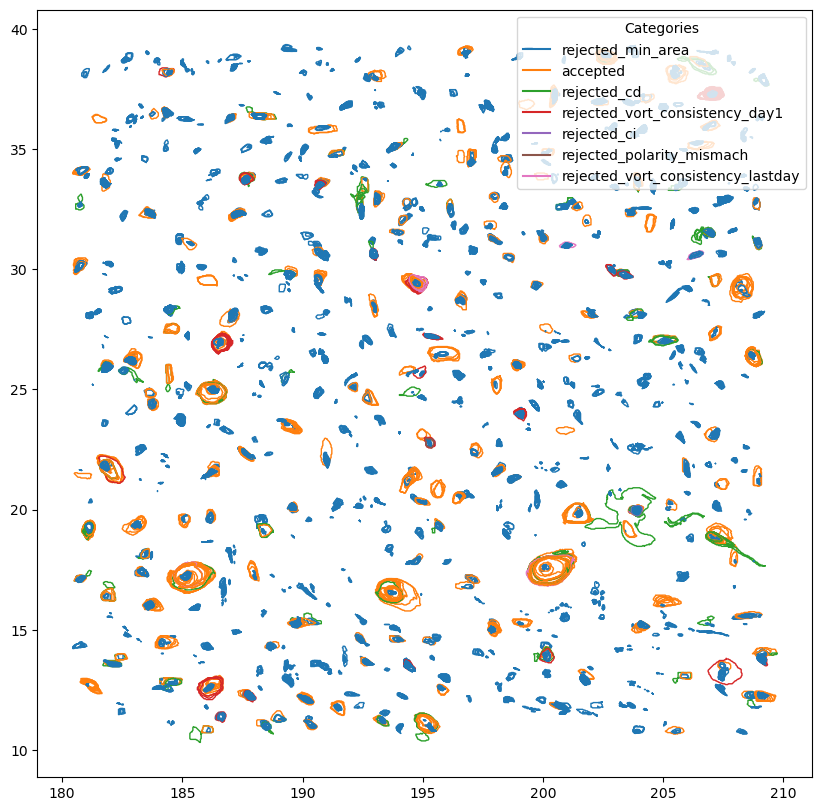

In [18]:
import matplotlib.colors as mcolors

gdf = gpd.GeoDataFrame(df, geometry='Polygon')
categories = gdf['reject_accept'].unique()
color_map = {category: color for category, color in zip(categories, mcolors.TABLEAU_COLORS)}
gdf['edge_color'] = gdf['reject_accept'].map(color_map)

fig, ax = plt.subplots(figsize=(10, 10))
# plt.xlim([198, 205])  
# plt.ylim([17, 22])


gdf.plot(ax=ax, edgecolor=gdf['edge_color'], facecolor='none', legend = True)
for category, color in color_map.items():
    ax.plot([], [], color=color, label=category)
ax.legend(title="Categories")
plt.show()

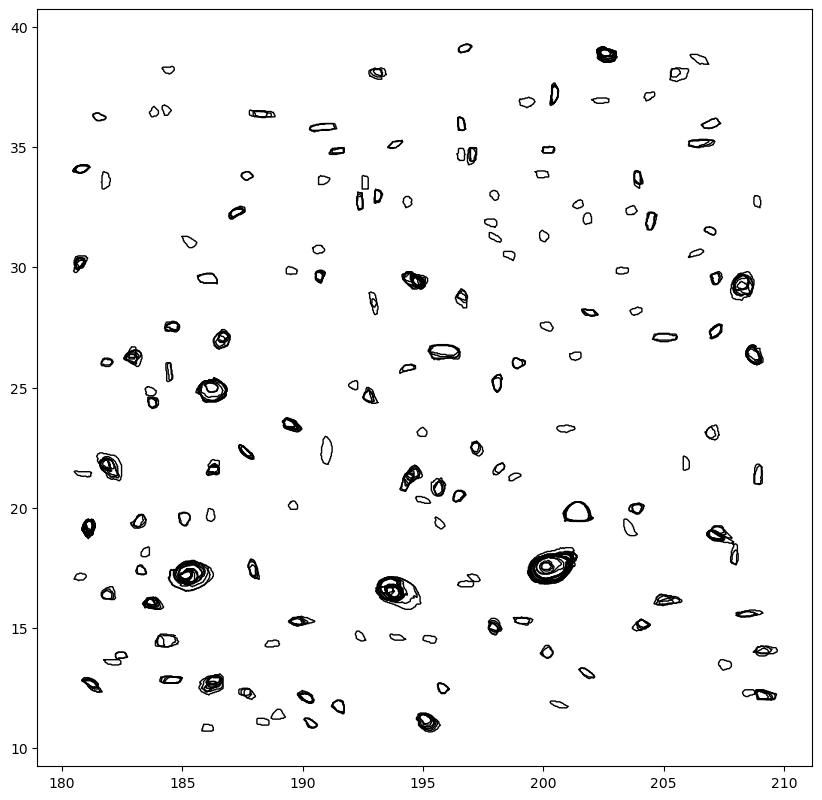

In [135]:
gdf = gpd.GeoDataFrame(df, geometry='Polygon')
fig, ax = plt.subplots(figsize=(10, 10))
# plt.xlim([198, 205])  
# plt.ylim([17, 22])
gdf.plot(ax=ax, edgecolor='black', facecolor='none')
plt.show()

In [20]:
df.to_pickle('/work/bk1377/b382618/LAVD_days_32_days_RCLVs_full.pickle')

In [134]:
df = pd.read_pickle('/work/bk1377/b382618/LAVD_days_32_days_RCLVs_full.pickle')

## Add group_id and age order for overlapping eddies

In [59]:
# from shapely.geometry import Polygon
# from shapely.strtree import STRtree
# import networkx as nx

# not using these but should

In [19]:
group_ids = [-1] * len(df)
current_id = 0

# Iterate through polygons to assign group IDs
for i, poly1 in enumerate(df["Polygon"]):
    if group_ids[i] == -1:# If not yet assigned, create a new group
        print(i)
        group_ids[i] = current_id
        for j, poly2 in enumerate(df["Polygon"]):
            if i != j and poly1.intersects(poly2):  # Check for overlap
                group_ids[j] = current_id
        current_id += 1

# Add group IDs to the DataFrame
df.loc[:, "group_id"] = group_ids

0
3
4
7
10
11
14
15
18
21
24
25
26
27
30
31
33
36
39
40
43
46
49
52
53
56
57
60
63
64
65
66
69
70
73
74
75
77
78
81
84
85
86
87
90
93
94
97
100
101
102
105
108
109
112
115
116
117
119
122
125
128
131
133
136
137
140
143
144
147
150
153
156
159
160
163
166
168
169
170
171
174
175
178
180
183
186
189
192
195
196
198
199
202
205
208
209
212
215
218
219
222
225
228
231
232
235
238
239
242
245
248
251
252
253
254
257
258
261
264
267
269
270
273
276
279
282
285
288
289
291
294
297
300
303
306
309
312
315
318
321
323
324
326
327
330
333
334
335
338
341
342
343
346
348
350
351
354
357
360
363
365
368
371
374
377
378
381
382
385
386
388
391
394
396
397
400
403
404
405
407
409
412
414
415
418
422
423
425
428
431
432
435
436
439
440
442
445
448
451
453
454
455
458
461
462
463
464
466
467
469
470
472
475
478
479
480
483
486
490
495
502
506
514
542
568
586
599
618
635
655
668
669
683
685
689
702
708
711
714
729
735
737
740
742
751
775
781
788
796
797
816
846
850
861
865
879
882
885
901
908
910
913


In [20]:
df['date'] = pd.to_datetime(df['date'])
# Rank polygons within each group based on the 'Date' column
df['age_order'] = df.groupby('group_id')["date"].rank(method='dense', ascending=True).astype(int) ## ascending=False for it being backwards trajectories

In [21]:
df

,date,reject_accept,RCLV_id,orientation,age_days,area_km2,center_lon,center_lat,CD,CI,flag,Points,Polygon,group_id,age_order
0,2010-04-24,rejected_min_area,nan,,nan,64.76424653211522,199.96875,17.46875,0.02332902563005996,,0,"['200.0', '17.5', '200.03125', '17.46875', '20...","POLYGON ((200 17.5, 200.03125 17.46875, 200.03...",0,1
1,2010-04-24,rejected_min_area,nan,,nan,61.55094419308734,199.96875,17.46875,0.020607925807497065,,0,"['200.0', '17.5', '200.03125', '17.46875', '20...","POLYGON ((200 17.5, 200.03125 17.46875, 200 17...",0,1
2,2010-04-24,rejected_min_area,nan,,nan,52.650777603291154,199.96875,17.46875,0.010057660578586227,,0,"['200.0', '17.5', '200.0', '17.5', '200.03125'...","POLYGON ((200 17.5, 200 17.5, 200.03125 17.468...",0,1
3,2010-04-24,rejected_min_area,nan,,nan,304.63808417735385,203.78125,20.03125,0.4613749905198093,,0,"['203.84375', '20.09375', '203.84375', '20.093...","POLYGON ((203.84375 20.09375, 203.84375 20.093...",1,1
6,2010-04-24,rejected_min_area,nan,,nan,137.28216024949646,199.6875,20.71875,0.03031260508700064,,0,"['199.75', '20.8125', '199.75', '20.78125', '1...","POLYGON ((199.75 20.8125, 199.75 20.78125, 199...",2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16918,2010-05-24,rejected_min_area,nan,,nan,188.02238814495635,198.34375,32.59375,0.09145865310326246,,0,"['198.375', '32.6875', '198.40625', '32.65625'...","POLYGON ((198.375 32.6875, 198.40625 32.65625,...",792,14
16919,2010-05-24,rejected_min_area,nan,,nan,176.18544047032546,198.34375,32.59375,0.009769225745521077,,0,"['198.375', '32.6875', '198.40625', '32.65625'...","POLYGON ((198.375 32.6875, 198.40625 32.65625,...",792,14
16920,2010-05-24,rejected_min_area,nan,,nan,50.57951908659911,199.875,31.46875,0.029644482634797093,,0,"['199.84375', '31.53125', '199.875', '31.5', '...","POLYGON ((199.84375 31.53125, 199.875 31.5, 19...",217,20
16921,2010-05-24,rejected_min_area,nan,,nan,47.980191969730434,199.875,31.46875,0.01938025695657512,,0,"['199.84375', '31.53125', '199.875', '31.5', '...","POLYGON ((199.84375 31.53125, 199.875 31.5, 19...",217,20


In [22]:
df.to_pickle('/work/bk1377/b382618/LAVD_days_32_days_RCLVs_full_rejects_newcd.pickle')

In [18]:
eddy = df[df['group_id']==1]
eddy

,date,reject_accept,RCLV_id,orientation,age_days,area_km2,center_lon,center_lat,CD,CI,flag,Points,Polygon,group_id,age_order
3,2010-04-24,rejected_min_area,nan,,nan,304.63808417735385,203.78125,20.03125,0.4613749905198093,,0,"['203.84375', '20.09375', '203.84375', '20.093...","POLYGON ((203.84375 20.09375, 203.84375 20.093...",1,1
7840,2010-05-08,rejected_min_area,nan,,nan,36.44801163980055,203.875,19.96875,0.019798446968822218,,0,"['203.875', '19.96875', '203.875', '19.9375', ...","POLYGON ((203.875 19.96875, 203.875 19.9375, 2...",1,2
7841,2010-05-08,rejected_min_area,nan,,nan,33.778669663143155,203.875,19.96875,0.009226720499665287,,0,"['203.875', '19.96875', '203.875', '19.9375', ...","POLYGON ((203.875 19.96875, 203.875 19.9375, 2...",1,2
8409,2010-05-09,rejected_min_area,nan,,nan,36.84013760170746,203.875,19.96875,0.030428492135175816,,0,"['203.875', '19.96875', '203.875', '19.9375', ...","POLYGON ((203.875 19.96875, 203.875 19.9375, 2...",1,3
8410,2010-05-09,rejected_min_area,nan,,nan,34.16142430203819,203.875,19.96875,0.01971062444392273,,0,"['203.875', '19.96875', '203.875', '19.9375', ...","POLYGON ((203.875 19.96875, 203.875 19.9375, 2...",1,3
8411,2010-05-09,rejected_min_area,nan,,nan,32.34302096718454,203.875,19.96875,0.01005781326610629,,0,"['203.875', '19.96875', '203.875', '19.9375', ...","POLYGON ((203.875 19.96875, 203.875 19.9375, 2...",1,3
8965,2010-05-10,rejected_min_area,nan,,nan,35.203524389986995,203.875,19.96875,0.03037169543437752,,0,"['203.875', '19.96875', '203.875', '19.9375', ...","POLYGON ((203.875 19.96875, 203.875 19.9375, 2...",1,4
8966,2010-05-10,rejected_min_area,nan,,nan,33.111271486583234,203.875,19.96875,0.020629572451361714,,0,"['203.875', '19.96875', '203.875', '19.9375', ...","POLYGON ((203.875 19.96875, 203.875 19.9375, 2...",1,4
8967,2010-05-10,rejected_min_area,nan,,nan,23.317446839458942,203.875,19.96875,0.009057400297559267,,0,"['203.875', '19.96875', '203.875', '19.96875',...","POLYGON ((203.875 19.96875, 203.875 19.96875, ...",1,4
9512,2010-05-11,rejected_min_area,nan,,nan,35.101454836569786,203.875,19.96875,0.030244454837172016,,0,"['203.875', '19.96875', '203.875', '19.9375', ...","POLYGON ((203.875 19.96875, 203.875 19.9375, 2...",1,5
